# Step 1. 스티커 구하기 or 만들기

- [cat wisk](https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1)
- [leonardo AI profile image](https://app.leonardo.ai/ai-generations/image-guidance)

In [245]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

In [246]:
!pwd
!ls

/aiffel/aiffel/2-1. 프로젝트: 고양이 수염 스티커 만들기
'프로젝트2 고양이 수염 스티커 만들기.ipynb'   groups.jpg
 cat-whiskers.png			      profile.jpg


In [247]:
base_dir = '/aiffel/aiffel/2-1. 프로젝트: 고양이 수염 스티커 만들기'
profile_path = f"{base_dir}/{'profile.jpg'}"
sticker_path = f"{base_dir}/{'cat-whiskers.png'}"

profile_path

'/aiffel/aiffel/2-1. 프로젝트: 고양이 수염 스티커 만들기/profile.jpg'

```cpp
enum  	cv::ImreadModes {
  cv::IMREAD_UNCHANGED = -1,
  cv::IMREAD_GRAYSCALE = 0,
  cv::IMREAD_COLOR = 1,
  cv::IMREAD_ANYDEPTH = 2,
  cv::IMREAD_ANYCOLOR = 4,
  cv::IMREAD_LOAD_GDAL = 8,
  cv::IMREAD_REDUCED_GRAYSCALE_2 = 16,
  cv::IMREAD_REDUCED_COLOR_2 = 17,
  cv::IMREAD_REDUCED_GRAYSCALE_4 = 32,
  cv::IMREAD_REDUCED_COLOR_4 = 33,
  cv::IMREAD_REDUCED_GRAYSCALE_8 = 64,
  cv::IMREAD_REDUCED_COLOR_8 = 65,
  cv::IMREAD_IGNORE_ORIENTATION = 128
}
```

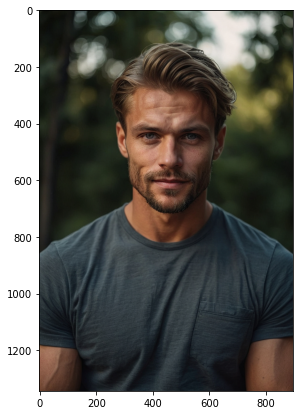

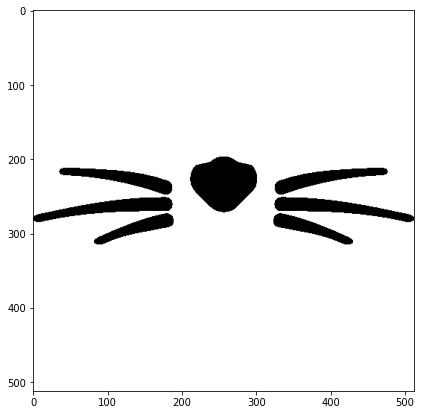

In [248]:
def plot_rectangle(img, rects):
    for rect in rects:
        l,t,r,b = rect.left(), rect.top(), rect.right(), rect.bottom()
        cv2.rectangle(img, (l, t), (r, b), (0, 255, 0), 3, lineType=cv2.LINE_AA)    

def plot_landmarks(img, landmarks, width=7):
    for landmark in landmarks:
        for point in landmark:
            cv2.circle(img, point, width, (0, 255, 255), -1)

def plot_rgb(img_bgr, landmarks=None, rectangles=None, figsize=(15, 7)):
    if rectangles:
        plot_rectangle(img_bgr, rectangles)
    if landmarks:
        plot_landmarks(img_bgr, landmarks)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(img_rgb)
    plt.show()


# origin
origin_profile_bgr = cv2.imread(profile_path, 1)
origin_sticker_bgr = cv2.imread(sticker_path, 1)

# copy
profile_show = origin_profile_bgr.copy()
sticker_show = origin_sticker_bgr.copy()

plot_rgb(profile_show)
plot_rgb(sticker_show)

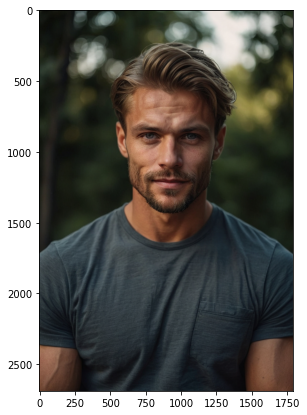

In [249]:
def get_copy_image():
    return origin_profile_bgr.copy()

def get_scaled_image():
    copy_image = get_copy_image()
    return cv2.pyrUp(copy_image)

plot_rgb(get_scaled_image())

In [250]:
profile_show.shape

(1344, 896, 3)

# Step 2. 얼굴 검출 & 랜드마크 검출 하기

- [x] dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아주세요.

- https://pyimagesearch.com/2021/04/19/face-detection-with-dlib-hog-and-cnn/

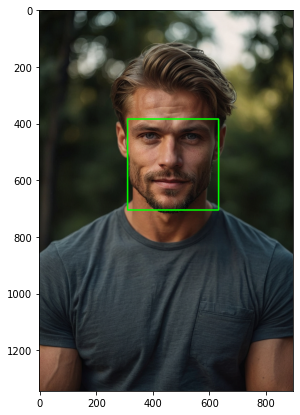

In [251]:
def handle_out_of_bound(image, rect):
    # Handle out of bound x,y
    start = (max(0, rect.left()), max(0,rect.top())) # (x, y)
    end = (min(image.shape[1], rect.right()), min(image.shape[0], rect.bottom()))
    return dlib.rectangle(start[0], start[1], end[0], end[1])


def get_facial_rects(image, arg_upsample = 1):
    detector = dlib.get_frontal_face_detector()
    rects = detector_hog(image, arg_upsample)
    boxes = [handle_out_of_bound(image, r) for r in rects]
    return boxes

rects = get_facial_rects(profile_show)
plot_rgb(get_copy_image(), rectangles=rects)

### 4 times scale

- 2w * 2h = 4times
- 반드시 origin을 copy해서 사용해야한다. 

> 4배 커진 이미지를 기반으로 detect하면 좀 더 얼굴을 잘 crop한걸 느낄 수 있다. 기존의 image에서는 오른쪽이 좀 크게 잡혔는데, 그 부분이 많이 개선되었다.



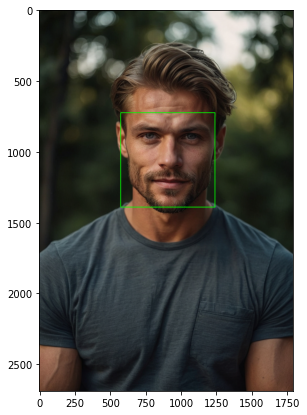

In [252]:
scaled_profile_show = get_scaled_image()
scaled_rects = get_facial_rects(scaled_profile_show)
plot_rgb(scaled_profile_show, rectangles=scaled_rects)

# Model Preparation

In [253]:
# old: shape_predictor_68_face_landmarks.dat.bz2
# new: shape_predictor_68_face_landmarks_GTX.dat.bz2
# https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks_GTX.dat.bz2

# ! wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks_GTX.dat.bz2
# ! mv shape_predictor_68_face_landmarks_GTX.dat.bz2 ~/aiffel/camera_sticker/models
# ! cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks_GTX.dat.bz2

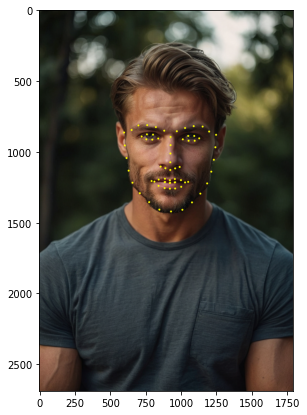

In [254]:
# Model prepare

base_model_path = '/aiffel/aiffel/camera_sticker/models'
# model_name = 'shape_predictor_68_face_landmarks.dat'
model_name = 'shape_predictor_68_face_landmarks_GTX.dat'
model_path = f'{base_model_path}/{model_name}'
landmark_predictor = dlib.shape_predictor(model_path)


def extract_landmarks(predictor, image, rects):
    list_landmarks = []
    for rect in rects:
        points = predictor(image, rect)    
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    return list_landmarks

scaled_profile_show = get_scaled_image()
list_landmarks = extract_landmarks(landmark_predictor, scaled_profile_show, get_facial_rects(scaled_profile_show))
plot_rgb(scaled_profile_show, list_landmarks)

# Step 3. 스티커 적용 위치 확인하기

- [x] 고양이 수염이 적용 될 위치를 landmark를 사용해서 계산해 주세요.

![](https://velog.velcdn.com/images%2Fchoi_4843%2Fpost%2F00b8e33c-79aa-4f7e-ac9f-478c708f000e%2F13.png)


- 스티커 center 위치가 30 (x,y)
- 스티커 width가 3 ~ 13 정도 이고
- 스티커 height가 27 ~ 8 정도 크기이면 딱 좋아보인다.

In [255]:
nose_idx = 30

# x,y,w,h
def get_points(rects, landmarks):
    points = []
    for rect, landmark in zip(rects, landmarks):
        w = landmark[13][0] - landmark[3][0]
        h = landmark[8][1] - landmark[27][1]

        x = landmark[nose_idx][0] - w//2
        y = landmark[nose_idx][1] - h//2

        print ('(x,y) : (%d,%d)'%(x,y))
        print ('(w,h) : (%d,%d)'%(w,h))
        points.append((x,y,w,h))
    return points
    
get_points(scaled_rects, list_landmarks)

(x,y) : (635,811)
(w,h) : (583,526)


[(635, 811, 583, 526)]

# Step 4. 스티커 적용하기

- [x] `np.where`를 사용해서 스티커를 적용해 주세요.
- [x] 스티커를 조금 더 자연스럽게 보이게 하려면 어떻게 해야 할까요? 스티커 뒤로 원본 이미지가 같이 보이도록 만들어 봅시다. opencv 의 `cv2.addWeighted()`를 참고하세요.


#### `addWeighted()`
$$g(x) = (1 - \alpha) f_0(x) + \alpha f_1(x)$$

```py
beta = (1.0 - alpha)
dst = cv.addWeighted(src1, alpha, src2, beta, 0.0)
```

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FnEquW%2FbtqJFZ4AeXX%2FFyN8KVML8vEkyrxA8qLD81%2Fimg.png)

(x,y) : (635,811)
(w,h) : (583,526)


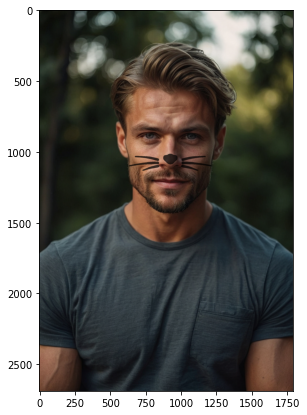

In [256]:
for (x,y,w,h) in get_points(scaled_rects, list_landmarks):
    # resize
    cat_sticker = origin_sticker_bgr.copy()
    cat_sticker = cv2.resize(cat_sticker, (w, h))

    # out of bound delete
    if x < 0: 
        cat_sticker = cat_sticker[:, -x:]
        x = 0
    if y < 0:
        cat_sticker = cat_sticker[-y:, :]
        y = 0

    # sticker area
    img_show = get_scaled_image()
    sticker_area = img_show[y:y+cat_sticker.shape[0], x:x+cat_sticker.shape[1]]

    alpha, beta = 0.25, 0.75
    weight = cv2.addWeighted(sticker_area, alpha, cat_sticker, beta, 0.0)
    img_show[y:y+cat_sticker.shape[0], x:x+cat_sticker.shape[1]] = \
        np.where(cat_sticker==0, weight, sticker_area).astype(np.uint8)    
    
    plot_rgb(img_show)

```py
img_show[y:y+cat_sticker.shape[0], x:x+cat_sticker.shape[1]] = \
        np.where(cat_sticker==0, weight, sticker_area).astype(np.uint8)    
```

- 원본 이미지의 스티커 영역에 할당하는 코드

```py
np.where(condition, x, y)

np.where(cat_sticker==0, weight, sticker_area).astype(np.uint8) 
```

- condition: 이때 0은 sticker의 투명한 영역을 의미하니, 고양이 스티커의 투명한 영역을 의미
- x: condition의 True인 요소들에 적용
- y: condition False인 요소들에 적용

# Wrap up

단체 사진을 넣어서 여러 명 처리해보기

In [257]:
base_dir = '/aiffel/aiffel/2-1. 프로젝트: 고양이 수염 스티커 만들기'
profile_path = f"{base_dir}/{'groups.jpg'}"
sticker_path = f"{base_dir}/{'cat-whiskers.png'}"

def plot_rectangle(img, rects):
    for rect in rects:
        l,t,r,b = rect.left(), rect.top(), rect.right(), rect.bottom()
        cv2.rectangle(img, (l, t), (r, b), (0, 255, 0), 3, lineType=cv2.LINE_AA)    

def plot_landmarks(img, landmarks, width=7):
    for landmark in landmarks:
        for point in landmark:
            cv2.circle(img, point, width, (0, 255, 255), -1)

def plot_rgb(img_bgr, landmarks=None, rectangles=None, figsize=(15, 7)):
    if rectangles:
        plot_rectangle(img_bgr, rectangles)
    if landmarks:
        plot_landmarks(img_bgr, landmarks)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(img_rgb)
    plt.show()


# origin
origin_profile_bgr = cv2.imread(profile_path, 1)
origin_sticker_bgr = cv2.imread(sticker_path, 1)

In [258]:
def get_copy_image():
    return origin_profile_bgr.copy()

def get_scaled_image():
    copy_image = get_copy_image()
    return cv2.pyrUp(copy_image)

def handle_out_of_bound(image, rect):
    # Handle out of bound x,y
    start = (max(0, rect.left()), max(0,rect.top())) # (x, y)
    end = (min(image.shape[1], rect.right()), min(image.shape[0], rect.bottom()))
    return dlib.rectangle(start[0], start[1], end[0], end[1])


def get_facial_rects(image, arg_upsample = 1):
    detector = dlib.get_frontal_face_detector()
    rects = detector_hog(image, arg_upsample)
    boxes = [handle_out_of_bound(image, r) for r in rects]
    return boxes

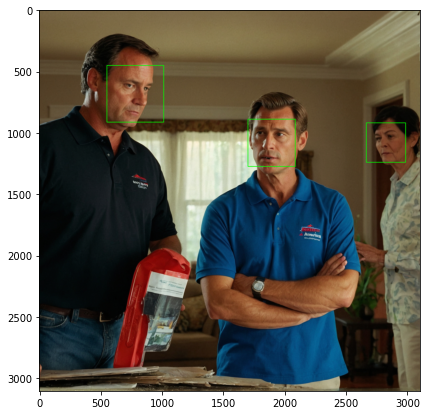

In [259]:
scaled_profile_show = get_scaled_image()
scaled_rects = get_facial_rects(scaled_profile_show)
plot_rgb(scaled_profile_show, rectangles=scaled_rects)

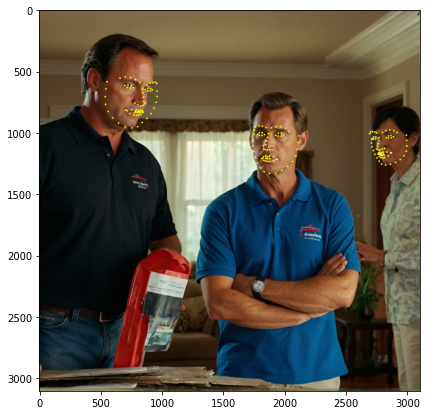

In [260]:
base_model_path = '/aiffel/aiffel/camera_sticker/models'
model_name = 'shape_predictor_68_face_landmarks_GTX.dat'
model_path = f'{base_model_path}/{model_name}'
landmark_predictor = dlib.shape_predictor(model_path)
def extract_landmarks(predictor, image, rects):
    list_landmarks = []
    for rect in rects:
        points = predictor(image, rect)    
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    return list_landmarks

scaled_profile_show = get_scaled_image()
list_landmarks = extract_landmarks(landmark_predictor, scaled_profile_show, get_facial_rects(scaled_profile_show))
plot_rgb(scaled_profile_show, list_landmarks)

**마스크의 볼 부분을 잡아내는 것이 어색하니, Width를 볼 전체 너비가 아닌, 48 ~ 54(입술 width)크기의 1.5배 길이로 mask를 처리해보자**

특히 비스듬한 인물의 얼굴 형태를 잡는 것이 크게 어색하다.

In [261]:
nose_idx = 30
# x,y,w,h
def get_points(rects, landmarks):
    points = []
    for rect, landmark in zip(rects, landmarks):
        w = round((landmark[54][0] - landmark[48][0]) * 1.5)
        h = landmark[8][1] - landmark[27][1]

        x = landmark[nose_idx][0] - w//2
        y = landmark[nose_idx][1] - h//2

        print ('(x,y) : (%d,%d)'%(x,y))
        print ('(w,h) : (%d,%d)'%(w,h))
        points.append((x,y,w,h))
    return points
    
get_points(scaled_rects, list_landmarks)

(x,y) : (2677,1002)
(w,h) : (164,222)
(x,y) : (745,586)
(w,h) : (216,318)
(x,y) : (1751,936)
(w,h) : (192,324)


[(2677, 1002, 164, 222), (745, 586, 216, 318), (1751, 936, 192, 324)]

(x,y) : (2677,1002)
(w,h) : (164,222)
(x,y) : (745,586)
(w,h) : (216,318)
(x,y) : (1751,936)
(w,h) : (192,324)


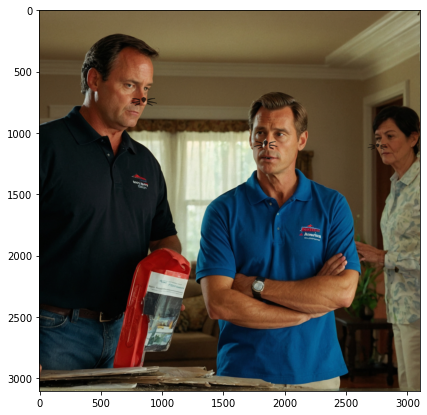

In [262]:
img_show = get_scaled_image()
for (x,y,w,h) in get_points(scaled_rects, list_landmarks):
    # resize
    cat_sticker = origin_sticker_bgr.copy()
    cat_sticker = cv2.resize(cat_sticker, (w, h))

    # out of bound delete
    if x < 0: 
        cat_sticker = cat_sticker[:, -x:]
        x = 0
    if y < 0:
        cat_sticker = cat_sticker[-y:, :]
        y = 0

    # sticker area
    sticker_area = img_show[y:y+cat_sticker.shape[0], x:x+cat_sticker.shape[1]]
    
    # weighted sticker
    alpha, beta = 0.25, 0.75
    weight = cv2.addWeighted(sticker_area, alpha, cat_sticker, beta, 0.0)
    img_show[y:y+cat_sticker.shape[0], x:x+cat_sticker.shape[1]] = \
        np.where(cat_sticker==0, weight, sticker_area).astype(np.uint8)    
    
plot_rgb(img_show)

**아래는 기존의 방식으로 스티커를 추가했을 때의 결과입니다.**

(x,y) : (2625,1002)
(w,h) : (269,222)
(x,y) : (656,586)
(w,h) : (395,318)
(x,y) : (1676,936)
(w,h) : (342,324)
(x,y) : (2625,1002)
(w,h) : (269,222)
(x,y) : (656,586)
(w,h) : (395,318)
(x,y) : (1676,936)
(w,h) : (342,324)


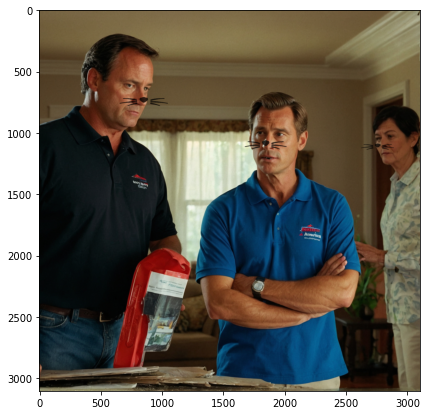

In [263]:
nose_idx = 30
# x,y,w,h
def get_points(rects, landmarks):
    points = []
    for rect, landmark in zip(rects, landmarks):
        w = landmark[13][0] - landmark[3][0]
        h = landmark[8][1] - landmark[27][1]

        x = landmark[nose_idx][0] - w//2
        y = landmark[nose_idx][1] - h//2

        print ('(x,y) : (%d,%d)'%(x,y))
        print ('(w,h) : (%d,%d)'%(w,h))
        points.append((x,y,w,h))
    return points
    
get_points(scaled_rects, list_landmarks)
img_show = get_scaled_image()
for (x,y,w,h) in get_points(scaled_rects, list_landmarks):
    # resize
    cat_sticker = origin_sticker_bgr.copy()
    cat_sticker = cv2.resize(cat_sticker, (w, h))

    # out of bound delete
    if x < 0: 
        cat_sticker = cat_sticker[:, -x:]
        x = 0
    if y < 0:
        cat_sticker = cat_sticker[-y:, :]
        y = 0

    # sticker area
    sticker_area = img_show[y:y+cat_sticker.shape[0], x:x+cat_sticker.shape[1]]
    
    # weighted sticker
    alpha, beta = 0.25, 0.75
    weight = cv2.addWeighted(sticker_area, alpha, cat_sticker, beta, 0.0)
    img_show[y:y+cat_sticker.shape[0], x:x+cat_sticker.shape[1]] = \
        np.where(cat_sticker==0, weight, sticker_area).astype(np.uint8)    
    
plot_rgb(img_show, figsize=(15,7))

#### 좀 더 landmark를 잘 따낼 수는 없을까?


- 뒤에 멀리 있는 여성의 경우에도 꽤나 잘 crop하고 있다.
- 뒤에 얼굴이 더 어두운 여성의 경우에도 꽤나 잘 crop하고 있다.
- 단 얼굴의 각도에 따라서는 landmark가 아쉽게 되고 있다. -> [Face Alignment Algorithm](https://medium.com/@dsfellow/precise-face-alignment-with-opencv-dlib-e6c8acead262)을 수행